[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 92, 93, 94, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,

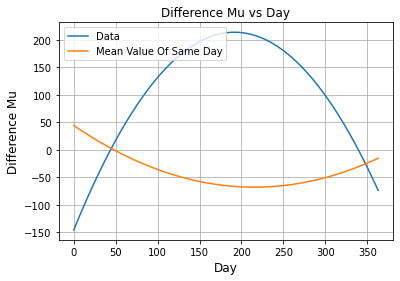

Elapsed time: 7.30344519999926


In [51]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from time import perf_counter
import timehorizonestimator

# convert to dataframe
df = [pd.read_csv("datasets/data3.csv"), pd.read_csv("datasets/flagstaffdata.csv")]

# input variables
dataset_num = 0
p = [[],[],[],[],[]]
xp = [[],[],[],[]] 
agg_x = [[],[],[],[]] 
agg_mu = [[],[],[],] 
g_cuttoff = 25

# statistics visualization
g_ps = [[],[]]
g_slopes = []
tempdiff_arr = []
g_mtrs = []
avg_mu = []
avg_lambda = []
mu_diff = [[],[]]
lambda_diff = []
day_arr = list(range(0, 364))
# end


def first_order_model(data, timehorizon):
    day = 0
    temperatureDayArr = []
    GHIDayArr = []
    for i in np.arange(int(len(data['Minute']))):
        if (data['Minute'][i] % 1440 == 0):
            if (day > 0):
                t0, t3 = timehorizonestimator.findt0t2t3(
                    temperatureDayArr, g_cuttoff)
                t2 = int(1/3*t0 + 2/3 * t3)
                g_ps[dataset_num].append((t3-t0)/10)

                sensitivity_analysis(max(temperatureDayArr),
                                     g_cuttoff)

                mut0t2 = 0
                sum_lambda = 0
                netflow = 0
                netflowt2t3 = 0
                sum_netflow = 0
                sum_mu = 0
                sum_lambda = 0
                slope = 1  # guessed
                eqn_queue = []
                mu_arr = []

                # t0 t2
                for k in np.arange(int(t0/timehorizon), int(t2/timehorizon)+1):
                    mut0t2 = ((GHIDayArr[int(t2/timehorizon)]-GHIDayArr[int(t0/timehorizon)])/(
                        (t2-t0)/timehorizon))*(k-t0/timehorizon)+GHIDayArr[int(t0/timehorizon)]
                    mu_arr.append(mut0t2)
                    sum_mu += mut0t2
                    netflow = GHIDayArr[int(k)] - mut0t2
                    sum_netflow += netflow

                queue = sum_netflow

                # total lambda for t2 t3
                for k in np.arange(int(t2/timehorizon), int(t3/timehorizon)+1):
                    sum_lambda += GHIDayArr[int(k)]

                # approximate slope
                func_approx(slope, sum_netflow, GHIDayArr[int(
                    int(t2/timehorizon))], GHIDayArr, sum_lambda, t2, t3, timehorizon, .2)

                # total lambda for t2 t3
                for k in np.arange(int(t0/timehorizon), int(t2/timehorizon)+1):
                    sum_lambda += GHIDayArr[int(k)]

                slope = g_slopes[len(g_slopes) - 1]

                # t2 - t3
                for k in np.arange(0, int(t3/timehorizon)-int(t2/timehorizon)):
                    y = slope*k + GHIDayArr[int(int(t2/timehorizon))]
                    sum_mu += y
                    netflowt2t3 = GHIDayArr[int(k) + int(t2/timehorizon)] - y
                    queue += netflowt2t3

                avg_mu.append((1 / (t3-t0)) * sum_mu)
                avg_lambda.append((1 / (t3-t0)) * sum_lambda)
                # eqn 1.1 (given)
                for k in np.arange(int(t0/timehorizon), int(t3/timehorizon)+1):
                    y = 1/3*((k - int(t0/timehorizon))**2) * \
                        (int(t3/timehorizon) - k)
                    eqn_queue.append(y)
                    mu_arr.append(y)
                mu_diff[dataset_num].append(
                    mu_arr[int(t2/timehorizon)-int(t0/timehorizon)] - mu_arr[0])
                lambda_diff.append(
                    GHIDayArr[int(t2/timehorizon)] - GHIDayArr[int(t0/timehorizon)])

                # print(eqn_queue)
                #print("queue t2 t3: " + str(queue))
                #print("queue t0 t2: " + str(sum_netflow))

            temperatureDayArr.clear()
            GHIDayArr.clear()
            day += 1
        temperatureDayArr.append(data['Average of Temperature'][i])
        GHIDayArr.append(data['Average of GHI'][i])


def sensitivity_analysis(maxtemp, cutoff):
    # mtr = magnitude of temperature reduction
    tempdiff = maxtemp - cutoff
    mtr = tempdiff/cutoff
    tempdiff_arr.append(tempdiff)
    g_mtrs.append(mtr)

def trim_values(bottom, top, val1, val2):
    #
    # print(bottom)
    temp1 = []
    temp2 = []
    for i in range(len(val1)):
        if (i >= bottom and i <= top):       
            temp1.append(val1[i])
            temp2.append(val2[i])
    return temp1, temp2
            
def plot_p():
    # Plot inflow rate
    fig = plt.figure()
    plt.plot(g_ps[0], 'r-', linewidth=3, label='Inflow rate')
    plt.ylabel('Hot Period (p)', fontsize=12)
    plt.xlabel('Day', fontsize=12)
    fig.savefig('Figures/p_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# inputs: x and input_val
# input value


def kdaysmoothing(x, input_val):
    agg_x = []
    y = []
    for i in np.arange(len(x)):

        total = 0
        average = 0
        count = 0
        for k in np.arange(len(x)):
            if (x[i] == x[k]):
                total += input_val[k]
                count += 1
        # since count is greater than 0, p value must exist
        if (count > 0):
            average = total / count
            dupe = False
            for j in range(len(y)):
                if (average == y[j]):
                    dupe = True
            if (dupe == False):
                y.append(average)
                agg_x.append(x[i])
    return agg_x, y


def plot_mtr():
    # Plot inflow rate
    ps, agg_mtr_vals = kdaysmoothing(g_ps[0], g_mtrs)

    cubic_fit = np.polyfit(ps, agg_mtr_vals, 2)
    p = np.poly1d(cubic_fit)
    xp = np.linspace(0, 144, 100)

    fig = plt.figure()

    plt.plot(g_ps[0], g_mtrs, '.', color='black', markersize=3)
    plt.scatter(ps, agg_mtr_vals, s=30, facecolors='none', edgecolors='r')

    plt.plot(xp, p(xp), '-', label='lienar')
    plt.legend(['Data', 'Mean Value Of Same P',
               'Estimated Curve'], loc='upper left')

    plt.xlabel('Hot Period (p)', fontsize=12)
    plt.ylabel('Magnitude Of Temperature Reduction', fontsize=12)
    plt.grid()

    plt.show()
    fig.savefig('Figures/mtr_vs_p.svg')

def findbestfit(x,i):
    aggx, aggmu = kdaysmoothing(x, mu_diff[i])
    
    print(aggx)
    
    cubic_fit = np.polyfit(aggx, aggmu, 2)
    p = np.poly1d(cubic_fit)
    xp = np.linspace(0, max(x), 500)
    return p,xp,aggx,aggmu

def plot_mu(x, x_var_name, p, xp, agg_x,agg_mu):
    


    fig = plt.figure()
    for i in range(len(df)):
        #plt.plot(x[i], mu_diff[i], '.', color='black', markersize=3)
        #plt.scatter(agg_x[i], agg_mu[i], s=30, facecolors='none', edgecolors='r')

        plt.plot(xp[i], p[i](xp[i]), '-')
        plt.legend(['Data', 'Mean Value Of Same ' + x_var_name,
               'Estimated Curve'], loc='upper left')

        plt.title('Difference Mu ' + 'vs ' + x_var_name)
        plt.xlabel(x_var_name, fontsize=12)
        plt.ylabel('Difference Mu', fontsize=12)
    
    plt.grid()

    plt.show()
    fig.savefig('Figures/avg_mu' + str(id(x)) + '.png')
    # approximates function from area bound and lambda(t)


def func_approx(slope, netflow, lambdat2, lambda_arr, total_lambda, t2, t3, timehorizon, step):
    total_mu = 0
    curr_netflow = 0
    queue = 0
    #y = mx+b
    # loops through a guessed slope and finds final queue
    for k in np.arange(0, int(t3/timehorizon)-int(t2/timehorizon)):
        y = slope*k + lambdat2
        # print(y)
        total_mu += y
        curr_netflow = y - lambda_arr[k + int(t2/timehorizon)]
        queue += curr_netflow

    # if the queue - netflow is within reasonable error return the correct linear slope

    if (abs(queue - netflow) < 1):
        #print("final slope: " + str(slope))
        #print("final netflow: " + str(netflow))
        #print("error: " + str(queue - netflow))
        #print("final queue: " + str(queue))
        g_slopes.append(slope)
    else:
        try:
            #print("slope: " + str(slope))
            #print("queue: " + str(queue))
            #print("netflow: " + str(queue - netflow))
            if (queue < netflow):
                slope += step
            if (queue > netflow):
                slope -= step

            # occassionaly breaks. There is probably a better method of attaining the correct answer
            if (abs(queue - netflow) < 500):
                step /= 1.005
            if (queue == 0.0):
                g_slopes.append(0)
            else:
                func_approx(slope, netflow, lambdat2, lambda_arr,
                        total_lambda, t2, t3, timehorizon, step)
        except:
            #print("netflow: " + str(queue - netflow))
            g_slopes.append(0)
if __name__ == "__main__":
    x_value = [day_arr,day_arr]
    
    t1_start = perf_counter()
    for i in range(len(df)):
        first_order_model(df[i],10)
        dataset_num += 1
        p[i], xp[i], agg_x[i],agg_mu[i] = findbestfit(x_value[i],i)
        
    
    t1_stop = perf_counter()
    # plot_p()
    # plot_mtr()
    #day_arr, mu_diff[dataset_num] = trim_values(0,364, day_arr, mu_diff[dataset_num])
    #print(p)
    plot_mu(x_value, "Day",p,xp,agg_x,agg_mu)
    print("Elapsed time:", t1_stop - t1_start)
